In [1]:
from qutip import (about, basis, expect, mesolve, qeye, sigmax, sigmay, sigmaz, tensor, mcsolve, sesolve, mesolve)
from qutip.expect import expect
import numpy as np
from samplers_util import thermal_rejection
import matplotlib.pyplot as plt
from basic_TFIM_funcs import get_s_lists
from joblib import Parallel, delayed


OMP: Info #276: omp_set_nested routine deprecated, please use omp_set_max_active_levels instead.


In [2]:

import os

#Move the directory back to Duke_Data
#Check if the current directory is Duke_Data
if os.getcwd().split('/')[-1] != 'DUKE_ANALOG_ZNE_DATA':
    #os.chdir('Duke_Data')
    os.chdir('../')
    #print(os.getcwd().split('/')[-1])
    #pass
else:
    pass
print(os.getcwd())
from index import print_index, get_experiment, index_folder
from functions_util import cetina_thermal_exp, cetina_envelope_exp
from scipy.optimize import curve_fit
import matplotlib.pyplot as plt
from matplotlib.colors import LinearSegmentedColormap
import matplotlib.cm as cm
import numpy as np
import h5py
from fitting_functions_ZNE import linear_ZNE, third_no_first_ZNE, quadratic_only_ZNE, exp_ZNE, log_fit_exp_ZNE


/Users/thomassteckmann/Duke_Analog_ZNE_data


In [3]:
# import all the useful lib in python
from matplotlib import artist as art
%matplotlib inline
import scipy as sp
# import pandas as pd
import pathlib
import os
import datetime as dt
import glob
from IPython.display import clear_output
from numpy.fft import fft, ifft

from h5analysis import *
from qsim_functions import*


In [4]:
#Pairs:
# wait_times = [0.000000, 0.119841, 0.359523, 0.719045, 0.958727, 1.198409, 1.797613, 2.396818, 3.595226]
# data_names = ['000558346','000558347','000558348','000558349','000558350','000558352']
# data_folder = 'Jij_Extrapolation'
data_names = ['217', '218', '219', '220', '221', '222', '223', '224', '225']
wait_times = [0.000000, 0.096831, 0.290494, 0.580987, 0.774650, 0.968312, 1.452468, 1.936624, 2.904936]
data_folder = 'ROUND_2_JIJ_MITIGATION'

pair = (12,13)
theta_0 = 0.056737213516413414
theta_dot = 0.024506055212502265
shots = 600
converter = 1/409.6
theta_list = theta_0+ theta_dot*np.array(wait_times)*converter*1e3
full_data_folder_path = './data/' + data_folder + '/'
for name_index in range(len(data_names)):
    name = data_names[name_index]
    if '000563' in name:
        pass
    else:
        name = '000563' + name
        data_names[name_index] = name
        

In [5]:
print()
COUNTS_THRESHOLD = 1

print(os.getcwd())



/Users/thomassteckmann/Duke_Analog_ZNE_data


In [6]:
results = np.zeros((len(data_names), 30))
leakage_matrix = np.zeros((30, len(data_names)))
flopping_matrix = np.zeros((30, len(data_names)))
flopping_std_matrix = np.zeros((30, len(data_names)))
times = None

for file_id_index in range(len(data_names)):
    file_id = data_names[file_id_index]
    #pair = names[0]
    file = h5py.File(full_data_folder_path + file_id + '-RFSoCSequence.h5', 'r')
    archive = file['archive']
    dataset = file['datasets']
    x_vals = dataset['data.rfsoc_pulse_sequence.x_values']
    times = np.array(x_vals)
    print(times)
    raw_counts = dataset['data.rfsoc_pulse_sequence.raw_counts']
    counts = np.asarray(raw_counts)
    print(counts.shape)
    measurements = np.zeros((2, shots, 30))
    for pair_index in range(len(pair)):
        qubit = pair[pair_index]
        measurements[pair_index,:,:] = 1 < counts[qubit,:,:]
        #print(measurements)
    #Convert the measurements to bitstrings. Convert to string, then append the like indices
    counts_bitstrings = np.zeros((shots, 30), dtype='<U5')
    expectations = np.zeros((shots, 30))
    for i in range(shots):
        for j in range(30):
            expectation = ((measurements[0,i,j]*2-1) - (measurements[1,i,j]*2-1))/2
            bitstring = str(int(measurements[0,i,j])) + str(int(measurements[1,i,j]))
            #print(bitstring)
            counts_bitstrings[i,j] = bitstring
            expectations[i,j] = expectation
    #average expectations across the 150 axis:
    expectations_avg = np.mean(expectations, axis=0)
    #Convert counts_bitstrings to a dictionary of counts
    print(counts_bitstrings)
    counts_array  = np.zeros((30,), dtype=dict)
    for i in range(30):
        counts_array[i] = {}
        for j in range(shots):
            if counts_bitstrings[j,i] in counts_array[i]:
                counts_array[i][counts_bitstrings[j,i]] += 1
            else:
                counts_array[i][counts_bitstrings[j,i]] = 1
                
    leakage = np.zeros((30,))
    for i in range(30):
        if '00' in counts_array[i]:
            leakage[i] = counts_array[i]['00']/shots
        if '11' in counts_array[i]:
            leakage[i] += counts_array[i]['11']/shots
    leakage_conv = np.zeros((30,))
    for i in range(30):
        leakage_conv[i] = np.mean(leakage[i:i+3])
    leakage_matrix[:,file_id_index] = leakage#leakage_conv
    flopping_matrix[:,file_id_index] = expectations_avg
    flopping_std = np.std(expectations, axis=0)
    flopping_std_matrix[:,file_id_index] = flopping_std

[0.         0.08413281 0.16826563 0.25239844 0.33653125 0.42066406
 0.50479688 0.58892969 0.6730625  0.75719531 0.84132812 0.92546094
 1.00959375 1.09372656 1.17785937 1.26199219 1.346125   1.43025781
 1.51439063 1.59852344 1.68265625 1.76678906 1.85092188 1.93505469
 2.0191875  2.10332031 2.18745313 2.27158594 2.35571875 2.43985156]
(23, 600, 30)
[['10' '10' '10' ... '01' '01' '11']
 ['10' '10' '11' ... '10' '01' '10']
 ['10' '10' '10' ... '01' '11' '00']
 ...
 ['10' '10' '11' ... '10' '01' '10']
 ['10' '10' '01' ... '10' '11' '01']
 ['10' '01' '10' ... '10' '01' '11']]
[0.         0.08413281 0.16826563 0.25239844 0.33653125 0.42066406
 0.50479688 0.58892969 0.6730625  0.75719531 0.84132812 0.92546094
 1.00959375 1.09372656 1.17785937 1.26199219 1.346125   1.43025781
 1.51439063 1.59852344 1.68265625 1.76678906 1.85092188 1.93505469
 2.0191875  2.10332031 2.18745313 2.27158594 2.35571875 2.43985156]
(23, 600, 30)
[['10' '10' '01' ... '11' '01' '10']
 ['10' '10' '01' ... '10' '11' '11'

In [7]:
#Fit each data set to exp(-gamma*t)*cos(omega*t)
#Create a new data set flopping_matrix_fit
flopping_matrix_fit = np.zeros(flopping_matrix.shape)
flopping_std_matrix_fit = np.zeros(flopping_matrix.shape)
def exp_func (t, gamma, omega, A):
    return A*np.exp(-gamma*t)*np.cos(omega*t)

print(flopping_matrix.shape)
for i in range(len(data_names)):
    popt, pcov = curve_fit(exp_func, times, flopping_matrix[:,i], p0=[0.04, 1, 1])
    print(exp_func(times, *popt))
    flopping_matrix_fit[:,i] = exp_func(times, *popt)
    #flopping_std_matrix_fit[:,i] = np.sqrt(np.diag(pcov))

(30, 9)
[ 0.88694538  0.73451246  0.42777242  0.05528898 -0.28885453 -0.52759218
 -0.61695216 -0.55264171 -0.36665599 -0.11580541  0.13427041  0.32537716
  0.41950398  0.40544799  0.2984582   0.13375406 -0.0438926  -0.19164887
 -0.27838838 -0.29064962 -0.23381806 -0.12878521 -0.00536364  0.10564811
  0.17975227  0.20376369  0.17763059  0.11299306  0.02917638 -0.05216334]
[ 0.9087146   0.74852159  0.43657264  0.06308124 -0.27877031 -0.51455036
 -0.60332007 -0.5428811  -0.36549812 -0.12625197  0.11239827  0.29583856
  0.38884673  0.38127047  0.28725972  0.13902487 -0.02277336 -0.15938435
 -0.24261173 -0.25997208 -0.21561631 -0.12732553 -0.02075421  0.07742031
  0.14573729  0.17222657  0.15598027  0.10599559  0.03789058 -0.03049188]
[ 0.87836831  0.70989652  0.39527667  0.03099806 -0.28839364 -0.49270446
 -0.54943808 -0.46617874 -0.28301411 -0.05824704  0.14821134  0.28944896
  0.34094264  0.3032268   0.19816589  0.06064392 -0.07167647 -0.16779071
 -0.2098358  -0.19548911 -0.13629342 -0.0

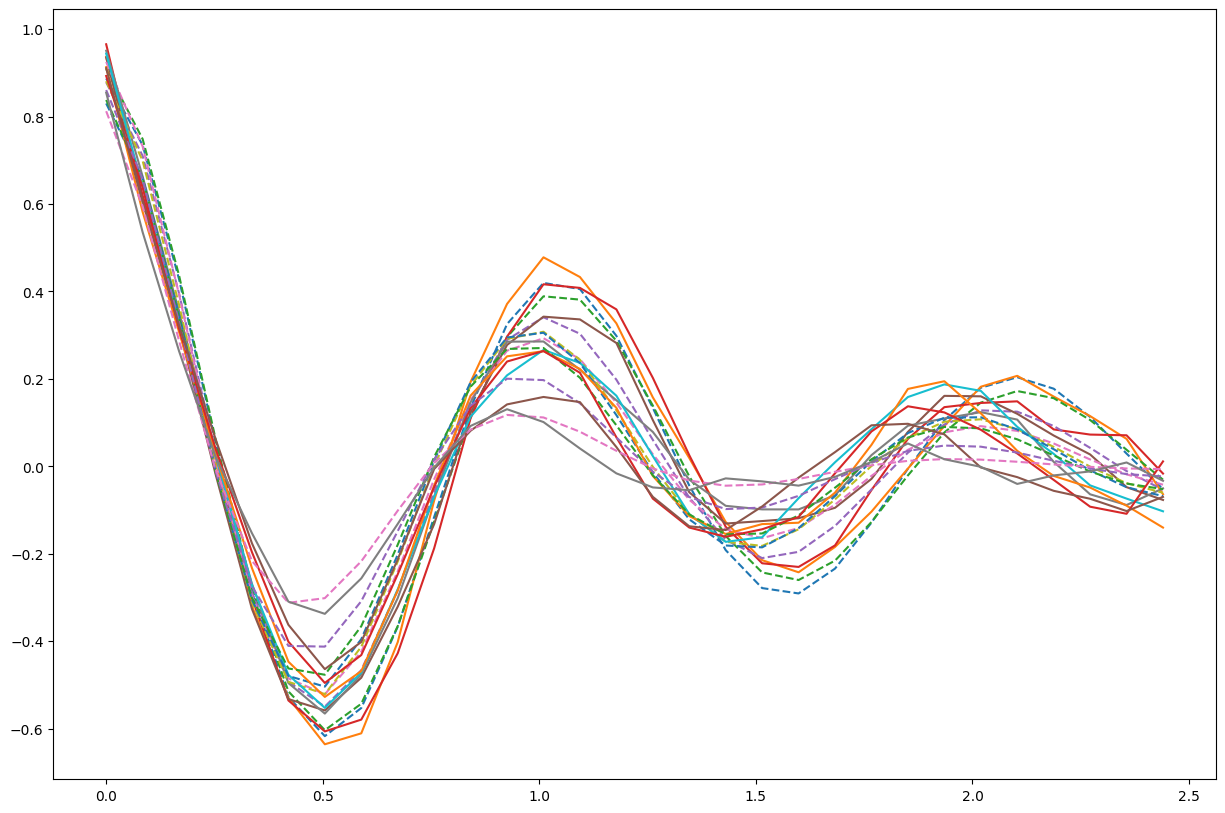

In [8]:
#Smooth out the data, not by taking an average over points but using fancier python methods
flopping_matrix_smooth = np.zeros(flopping_matrix.shape)
flopping_std_matrix_smooth = np.zeros(flopping_matrix.shape)

#Use teh Savitzky-Golay filter
from scipy.signal import savgol_filter
for i in range(len(data_names)):
    flopping_matrix_smooth[:,i] = savgol_filter(flopping_matrix[:,i], 5, 3)
    #flopping_std_matrix_smooth[i,:] = savgol_filter(flopping_std_matrix[i,:], 7, 2)

#Plot the data
fig, ax = plt.subplots(1,1, figsize=(15,10))
for i in range(len(data_names)):
    #ax.errorbar(times, flopping_matrix[i,:], yerr=flopping_std_matrix[i,:], fmt='o', label='Data ' + str(i))
    ax.plot(times, flopping_matrix_fit[:,i], label='Fit ' + str(i), linestyle='--')
    ax.plot(times, flopping_matrix_smooth[:,i], label='Smooth ' + str(i))




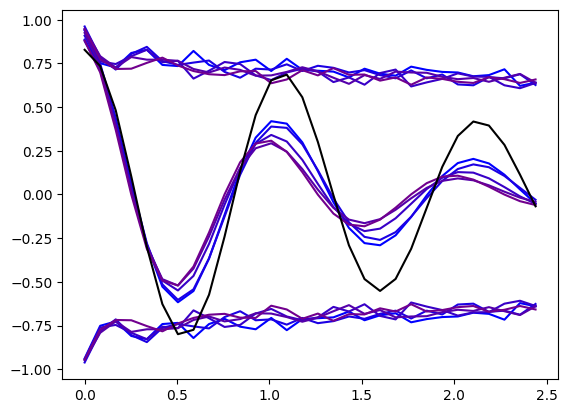

In [9]:
theta_sub_index = [0, 1, 2, 3, 4]#, 5,6,]
theta_sub_index_mask = [i in theta_sub_index for i in range(len(theta_list))]
weights_comp = np.array([1, 1, 1, 1, 1.5, 2,4])
weights_comp = np.ones(len(theta_sub_index))

ZNE_function = third_no_first_ZNE

cmap = LinearSegmentedColormap.from_list("mycmap", ["blue", "red"])
for index in range(len(theta_sub_index)):
    name_index = theta_sub_index[index]
    color = cmap(name_index/len(data_names))
    plt.plot(times, 1-leakage_matrix[:,name_index], label = data_names[name_index], color = color)
    plt.plot(times, flopping_matrix_fit[:,name_index], label = data_names[name_index], color = color)
    #plt.errorbar(times, flopping_matrix[:,name_index], label = data_names[name_index], yerr = flopping_std_matrix[:,name_index]/np.sqrt(shots), color = color)
    plt.plot(times, -1+leakage_matrix[:,name_index], label = data_names[name_index], color = color)


#Get ZNed Data:
ZNE_data = np.zeros(30)
for i in range(30):
    #fit_func = third_no_first_ZNE(theta_list[theta_sub_index_mask], flopping_matrix[i,theta_sub_index_mask])
    fit_func = ZNE_function(theta_list[theta_sub_index_mask], flopping_matrix_fit[i,theta_sub_index_mask], weights=flopping_std_matrix[i,theta_sub_index_mask]/np.sqrt(shots)*weights_comp)
    ZNE_data[i] = fit_func(0)

plt.plot(times, ZNE_data, label = 'ZNE', color = 'black')

Text(0, 0.5, 'Expectation Value <Z_0> - <Z_1>')

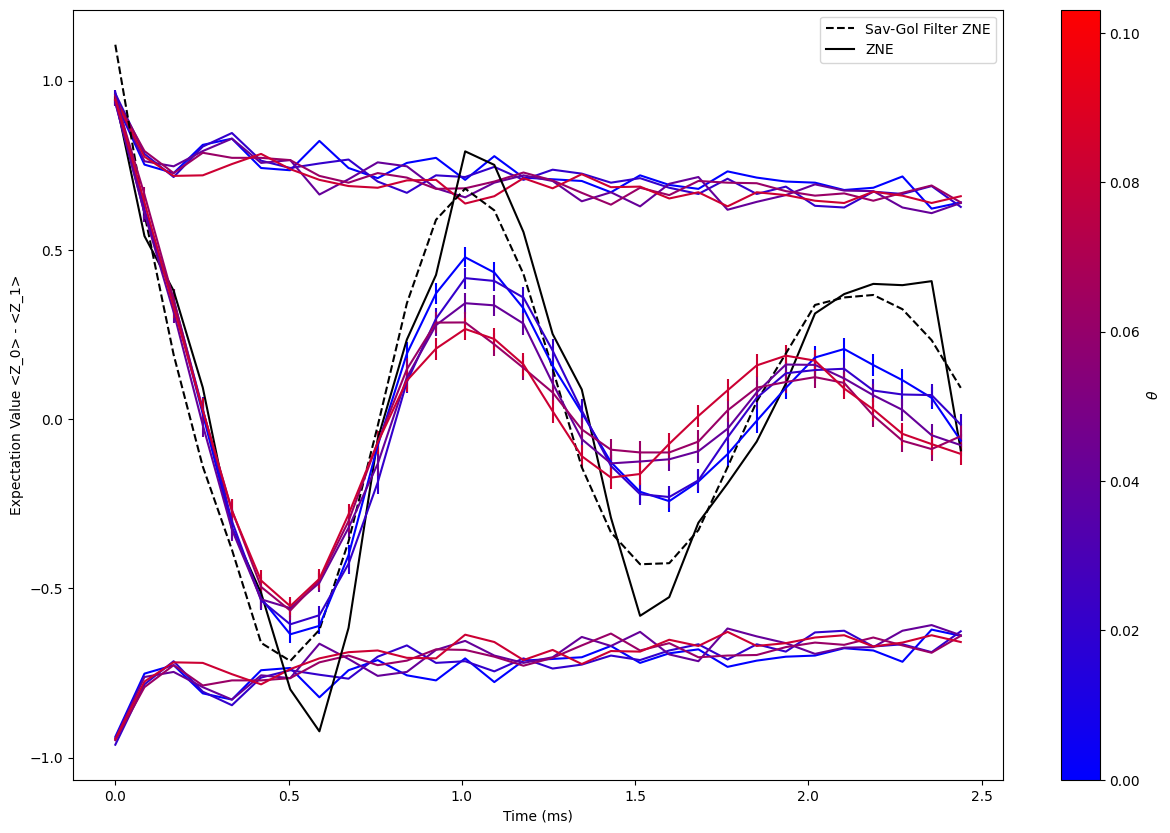

In [30]:
theta_sub_index = [0, 1, 2, 3, 4]#, 5,6,]
theta_sub_index_mask = [i in theta_sub_index for i in range(len(theta_list))]
weights_comp = np.array([1, 1, 1, 1, 1.5, 2,4])
weights_comp = np.ones(len(theta_sub_index))

fig, ax = plt.subplots(1,1, figsize=(15,10))

ZNE_function = third_no_first_ZNE

cmap = LinearSegmentedColormap.from_list("mycmap", ["blue", "red"])
for index in range(len(theta_sub_index)):
    name_index = theta_sub_index[index]
    color = cmap(name_index/len(theta_sub_index))
    ax.plot(times, 1-leakage_matrix[:,name_index],  color = color)
    #plt.plot(times, flopping_matrix_fit[:,name_index], label = data_names[name_index], color = color)
    ax.errorbar(times, flopping_matrix_smooth[:,name_index], yerr = flopping_std_matrix[:,name_index]/np.sqrt(shots), color = color)
    ax.plot(times, -1+leakage_matrix[:,name_index],  color = color)


#Get ZNed Data:
ZNE_data = np.zeros(30)
for i in range(30):
    #fit_func = third_no_first_ZNE(theta_list[theta_sub_index_mask], flopping_matrix[i,theta_sub_index_mask])
    fit_func = ZNE_function(theta_list[theta_sub_index_mask], flopping_matrix_smooth[i,theta_sub_index_mask], weights=flopping_std_matrix[i,theta_sub_index_mask]/np.sqrt(shots)*weights_comp)
    ZNE_data[i] = fit_func(0)
    
#Apply the Sav-Gol filter to the ZNE data
ZNE_data_smooth = savgol_filter(ZNE_data, 10, 2)
ax.plot(times, ZNE_data_smooth, label = 'Sav-Gol Filter ZNE', color = 'black', linestyle = '--')

ax.plot(times, ZNE_data, label = 'ZNE', color = 'black')

ax.legend()

sm = plt.cm.ScalarMappable(cmap=cmap, norm=plt.Normalize(vmin=0, vmax=max(theta_list[theta_sub_index_mask])))
#sm.set_label('Temperature (Theta)')
#Add the color bar to the plot:

cbar = fig.colorbar(sm, ax=ax)

cbar.set_label(r'$\theta$')

ax.set_xlabel('Time (ms)')
ax.set_ylabel('Expectation Value <Z_0> - <Z_1>')

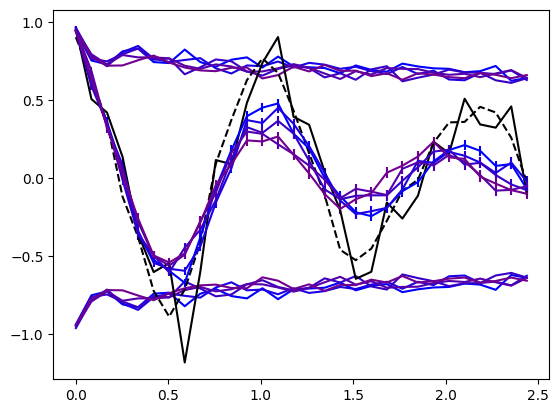

In [41]:
theta_sub_index = [0, 1, 2, 3, 4]#, 5,6,]
theta_sub_index_mask = [i in theta_sub_index for i in range(len(theta_list))]
weights_comp = np.array([1, 1, 1, 1, 1.5, 2,4])
weights_comp = np.ones(len(theta_sub_index))

ZNE_function = third_no_first_ZNE

cmap = LinearSegmentedColormap.from_list("mycmap", ["blue", "red"])
for index in range(len(theta_sub_index)):
    name_index = theta_sub_index[index]
    color = cmap(name_index/len(data_names))
    plt.plot(times, 1-leakage_matrix[:,name_index], label = data_names[name_index], color = color)
    #plt.plot(times, flopping_matrix_fit[:,name_index], label = data_names[name_index], color = color)
    plt.errorbar(times, flopping_matrix[:,name_index], label = data_names[name_index], yerr = flopping_std_matrix[:,name_index]/np.sqrt(shots), color = color)
    plt.plot(times, -1+leakage_matrix[:,name_index], label = data_names[name_index], color = color)


#Get ZNed Data:
ZNE_data = np.zeros(30)
for i in range(30):
    #fit_func = third_no_first_ZNE(theta_list[theta_sub_index_mask], flopping_matrix[i,theta_sub_index_mask])
    fit_func = ZNE_function(theta_list[theta_sub_index_mask], flopping_matrix[i,theta_sub_index_mask], weights=flopping_std_matrix[i,theta_sub_index_mask]/np.sqrt(shots)*weights_comp)
    ZNE_data[i] = fit_func(0)
    
ZNE_data_smooth = savgol_filter(ZNE_data, 6, 2)
plt.plot(times, ZNE_data_smooth, label = 'Sav-Gol Filter ZNE', color = 'black', linestyle = '--')


plt.plot(times, ZNE_data, label = 'ZNE', color = 'black')

[1.         1.10210802 1.30632513 1.6126492  1.8168663  2.02108235
 2.53162353 3.04216471 4.06324706]


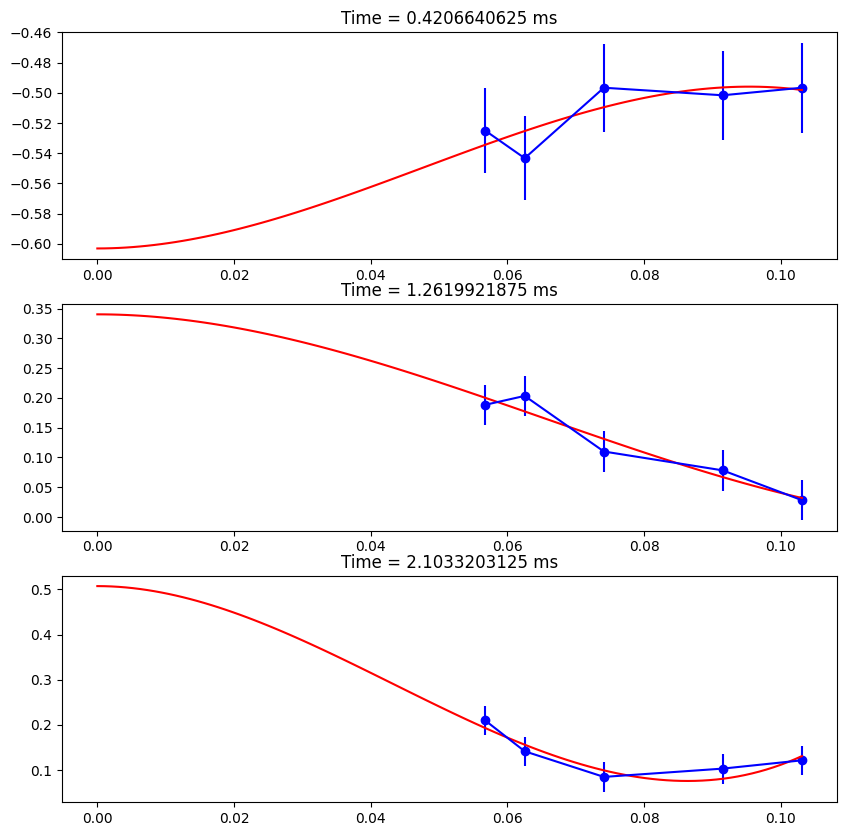

In [36]:
peak_indices = [5,15,25]
#create 3 subplots. at the peak index, plot vs. theta, fit to cubic_no_first, and plot the fit
#thetas_sub_index = 
print(theta_list/theta_list[0])

fig, axes = plt.subplots(3)

for i in range(3):
    axis = axes[i]
    axis.scatter(theta_list[theta_sub_index_mask], flopping_matrix[peak_indices[i],theta_sub_index_mask], label = 'Data', color = 'blue')
    axis.errorbar(theta_list[theta_sub_index_mask], flopping_matrix[peak_indices[i],theta_sub_index_mask], yerr = flopping_std_matrix[peak_indices[i],theta_sub_index_mask]/np.sqrt(shots)*weights_comp, label = 'Data', color = 'blue')
    fit_func = ZNE_function(theta_list[theta_sub_index_mask], flopping_matrix[peak_indices[i],theta_sub_index_mask], weights=flopping_std_matrix[peak_indices[i],theta_sub_index_mask]/np.sqrt(shots)*weights_comp)#, flopping_matrix[peak_indices[i],1], flopping_matrix[peak_indices[i],2], flopping_matrix[peak_indices[i],3])
    dense_theta = np.linspace(0, theta_list[theta_sub_index_mask][-1], 100)
    axis.plot(dense_theta, fit_func(dense_theta), label = 'Fit', color = 'red')
    axis.set_title('Time = ' + str(times[peak_indices[i]]) + ' ms')
    #Make the plots bigger:
    
fig.set_size_inches(10, 10)
    
    
    